<a href="https://colab.research.google.com/github/pachterlab/monod/blob/nn-integration/Inference_Timing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -b nn-integration https://github.com/pachterlab/monod.git

Cloning into 'monod'...
remote: Enumerating objects: 753, done.
remote: Counting objects: 100% (410/410), done.
remote: Compressing objects: 100% (277/277), done.
remote: Total 753 (delta 222), reused 242 (delta 132), pack-reused 343
Receiving objects: 100% (753/753), 2.25 MiB | 16.69 MiB/s, done.
Resolving deltas: 100% (408/408), done.


In [5]:
# dependencies
!pip install -q loompy
!pip install -q anndata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 43.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 KB 3.7 MB/s eta 0:00:00


In [6]:
import sys
sys.path.insert(0, '/content/monod/src')

In [7]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [8]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy

In [9]:
!pwd

/content


In [10]:
# load in data
# data already pre-formatted to be correct format for monod
# can import and load whatever data you want
data_path = 'sample_data/raw.sd'
search_data = monod.analysis.load_search_data(data_path)

In [11]:
result_strings = []
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [1,1]
samp_ub = [1,1]
gridsize = [1,1]

In [37]:
# Fit using fixed quad
dir_path = './sample_data/'
fitmodel_fq = monod.cme_toolbox.CMEModel('Bursty','None')
inference_parameters_fq = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
            dir_path,fitmodel_fq,use_lengths = False,
            gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
#full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
#result_strings.append(full_result_string)

In [38]:
# Fit using bursty nn

dir_path = './sample_data/'
fitmodel_nn = monod.cme_toolbox.CMEModel('Bursty','None',quad_method='nn')
inference_parameters_nn = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
            dir_path,fitmodel_nn,use_lengths = False,
            gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
#full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
#result_strings.append(full_result_string)

In [39]:
fitmodel_qv = monod.cme_toolbox.CMEModel('Bursty','None',quad_method='quad_vec')
inference_parameters_qv = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
            dir_path,fitmodel_qv,use_lengths = False,
            gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})

# Comparisons

In [40]:
import time

In [41]:
grad_inference_fq = monod.inference.GradientInference(inference_parameters_fq, fitmodel_fq, search_data, 0)
grad_inference_qv = monod.inference.GradientInference(inference_parameters_qv, fitmodel_qv, search_data, 0)
grad_inference_nn = monod.inference.GradientInference(inference_parameters_nn, fitmodel_nn, search_data, 0)

In [42]:
N = 25


t_fq = np.ones(N)
for i in range(N):
    t1 = time.time()
    grad_inference_fq.optimize_gene(i,fitmodel_fq,search_data)
    t_fq[i] = (time.time()-t1)


t_qv = np.ones(N)
for i in range(N):
    t1 = time.time()
    grad_inference_qv.optimize_gene(i,fitmodel_qv,search_data)
    t_qv[i] = (time.time()-t1)



t_nn = np.ones(N)
for i in range(N):
    t1 = time.time()
    grad_inference_nn.optimize_gene(i,fitmodel_nn,search_data)
    t_nn[i] = (time.time()-t1) 
    

/content/monod/src/monod/nn_toolbox.py:472: RuntimeWarning: divide by zero encountered in log
  return(np.log(P.numpy()))


Text(0, 0.5, 'NN time')

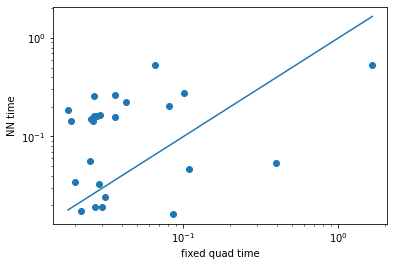

In [46]:
plt.scatter(t_fq,t_nn)
xl = [t_fq.min(),t_fq.max()]
plt.plot(xl,xl)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('fixed quad time')
plt.ylabel('NN time')

0.11945179939270019


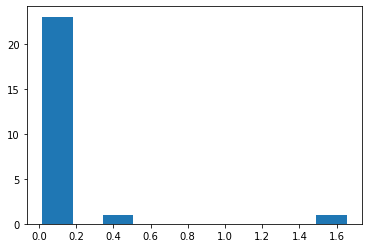

In [52]:
plt.hist(t_fq);
print(np.mean(t_fq));

0.15547703742980956


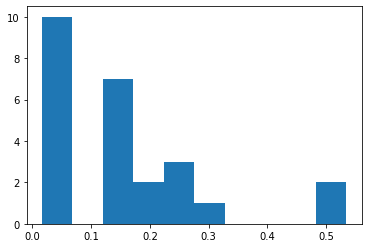

In [51]:
plt.hist(t_nn);
print(np.mean(t_nn));

Text(0, 0.5, 'NN time')

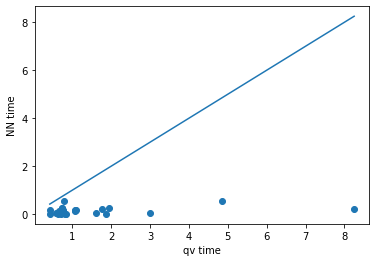

In [47]:
plt.scatter(t_qv,t_nn)
xl = [t_qv.min(),t_qv.max()]
plt.plot(xl,xl)
plt.xlabel('qv time')
plt.ylabel('NN time')

Text(0, 0.5, 'qv time')

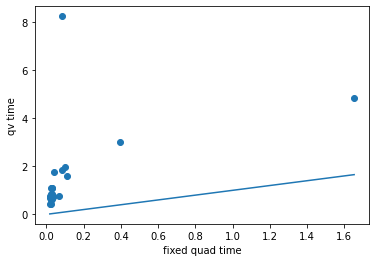

In [48]:
plt.scatter(t_fq,t_qv)
xl = [t_fq.min(),t_fq.max()]
plt.plot(xl,xl)
plt.xlabel('fixed quad time')
plt.ylabel('qv time')